In [87]:
import numpy as np
from sklearn.preprocessing import normalize
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import warnings
# warnings.filterwarnings("ignore")

In [88]:
A = np.array([
    [.1, .2, .05, .8, .9, .7, .5, .4, .45],
    [.5, .45, .55, .1, .05, .1, .1, .2, .15],
    [.4, .35, .4, .1, .05, .2, .4, .4, .4]
])

C = np.array([
    [1000, 0, 0],
    [500, 0, 0],
    [2000, 0, 0],
    [0, 500, 0],
    [0, 400, 0],
    [0, 5000, 0],
    [0, 0, 1000],
    [0, 0, 100],
    [0, 0, 500]
])

## Original Matrix

In [89]:
px.imshow(A, width=500)

## Matrix Multiplication

$$I = (C\quad\emptyset\quad\hat{j}C)A$$

In [90]:
C_norm = C / np.array([1 for _ in range(9)]).dot(C)
I = C_norm.dot(A)
px.imshow(I, width=500)

## Iterative Proportional Fitting

Iterate these two steps on P [source](https://www.researchgate.net/publication/336917269_What_is_Iterative_Proportional_Fitting)

$$(1)\quad P_{ij(k+1)}=(\frac{P_{ij(k)}}{\sum_jP_{ij(k)}}) Q_i$$

$$(2)\quad P_{ij(k+2)}=(\frac{P_{ij(k+1)}}{\sum_iP_{ij(k+1)}}) Q_j$$

In [91]:
SEEDER = np.array([
    [1/3, 0, 0],
    [1/3, 0, 0],
    [1/3, 0, 0],
    [0, 1/3, 0],
    [0, 1/3, 0],
    [0, 1/3, 0],
    [0, 0, 1/3],
    [0, 0, 1/3],
    [0, 0, 1/3],
])

SEED = SEEDER.dot(A)
capital_margin = C_norm.sum(axis=1)

The algorithm converges after one iteration because all of the column margins are already equal to the column sums in the SEED matrix. To get more value out of iterations, we would have to have country/sector total capital expenditure values that are considered more reliable.

In [92]:
# column_margin = np.array([1 + np.random.normal(0,.1) for  _ in range(9)])
column_margin = SEED.sum(axis=0)
column_margin

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [93]:
def iter_prop_fit(df, row_margin, col_margin, iters):

    for iter in range(iters):

        next_S1 = df.copy()
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                next_S1.iloc[i,j] = row_margin[i] * df.iloc[i,j] / (df.sum(axis=1, skipna=True)[i] + 1e-20)

        next_S2 = next_S1.copy()
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                next_S2.iloc[i,j] = col_margin[j] * next_S1.iloc[i,j] / (next_S1.sum(axis=0,skipna=True)[j] + 1e-20)

        df = next_S2.copy()
        
    return next_S2

SEED = iter_prop_fit(pd.DataFrame(SEED), capital_margin, column_margin, 10)

Text(0.5, 1.0, 'Iterative Proportional')

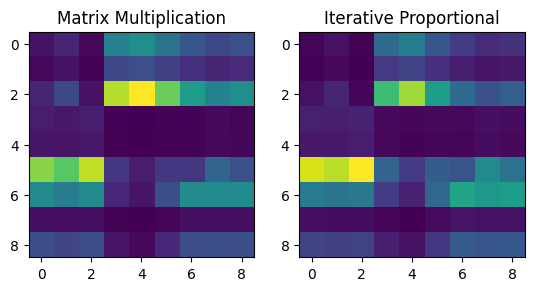

In [94]:
fig, axes = plt.subplots(1,2)

axes[0].imshow(I)
axes[0].set_title("Matrix Multiplication")
axes[1].imshow(SEED)
axes[1].set_title("Iterative Proportional")

# ICIO Weighting

In [95]:
icio_df = pd.read_csv('raw_data/ICIO2021_2014.csv', index_col=0)
expend_df = pd.read_csv('raw_data/SNA_TABLE8A.csv')
exchange_rates = pd.read_csv('raw_data/exchange_rates.csv', index_col=0)
recipe_df = pd.read_csv("investment_recipe.csv", index_col=0)

# remoe postal/courier since no data
recipe_df.drop("53", axis=0, inplace=True)
recipe_df.drop("53", axis=1, inplace=True)

# remove government since no data
recipe_df.drop("84", axis=0, inplace=True)
recipe_df.drop("84", axis=1, inplace=True)

In [96]:
expend_df2 = expend_df[["LOCATION", "ACTIVITY", "TIME", "Value"]][expend_df["TIME"] == 2014]
expend_df2.reset_index(inplace=True, drop=True)

for i, row in expend_df2.iterrows():
    expend_df2.iloc[i, 3] = row["Value"] / exchange_rates.loc[row["LOCATION"], "2014"]

In [97]:
expend_df2

,LOCATION,ACTIVITY,TIME,Value
0,AUT,V22,2014,808.924303
1,CZE,V22,2014,860.969265
2,FIN,V22,2014,164.674635
3,ISL,V22,2014,1.795764
4,MEX,V22,2014,5.081929
...,...,...,...,...
2029,LVA,V07,2014,0.000000
2030,LVA,V08,2014,38.110226
2031,LVA,V08,2014,39.353254
2032,LVA,V09,2014,0.338645


In [98]:
activity_sector_map = {
    '01T02': ['V01', 'V02'], 
    '03': ['V03'], 
    '05T06': ['V05', 'V06'], 
    '07T08': ['V07', 'V08'], 
    '09': ['V09'], 
    '10T12': ['V10_12'], 
    '13T15': ['V13_15'], 
    '16': ['V16'], 
    '17T18': ['V17', 'V18'], 
    '19': ['V19'], 
    '20': ['V20'], 
    '21': ['V21'], 
    '22': ['V22'],  
    '23': ['V23'], 
    '24': ['V24'], 
    '25': ['V25'], 
    '26': ['V26'], 
    '27': ['V27'], 
    '28': ['V28'], 
    '29': ['V29'], 
    '30': ['V30'], 
    '31T33': ['V31_33'], 
    '35': ["VD"], 
    '36T39': ["VE"], 
    '41T43': ["VF"], 
    '45T47': ["VG"], 
    '49': ["V49"], 
    '50': ["V50"], 
    '51': ["V51"], 
    '52': ["V52"], 
    '53': ["V53"], 
    '55T56': ["VI"], 
    '58T60': ["V58_60"], 
    '61': ["V61"], 
    '62T63': ["V62_63"], 
    '64T66': ["VK"], 
    '68': ["VL"], 
    '69T75': ["VM"], 
    '77T82': ["VN"], 
    '84': ["V0"], 
    '85': ["VP"], 
    '86T88': ["VQ"], 
    '90T93': ["VR"], 
    '94T96': ["VS"]
}

In [99]:
rows = []

for country in expend_df2["LOCATION"].unique():
    for key, vals in activity_sector_map.items():

        vals = expend_df2.loc[
            (expend_df2["LOCATION"] == country)
            & (expend_df2["ACTIVITY"].map(lambda x: x in vals)), 
            "Value"
        ]

        if len(vals) == 0:
            val = np.nan
        else:
            val = np.sum(vals)

        rows.append({
            "cou": country,
            "sec": key,
            "val": val
        })

expend_df3 = pd.DataFrame(rows)
expend_df3.index = expend_df3["sec"]

### Using Only ICIO Data

$I$ is the international investment matrix where $al$ is the producing sector $l$ in country $a$ and $bm$ is the consuming sector $m$ in country $b$.

$$I_{(al)(bm)}$$

We have $P_{(al)b}$ from the ICIO, total production for each country/sector $al$ that is consumed by each country $b$, and we have $R_{lm}$, the intensive form of the inter sectoral investment recipe based on Vom-Lehn Winberry where $\sum_{l,m}R_{lm}=1$. For each pair of countries $a_0$ and $b_0$, we use $P_{(al)b}$ to empirically weight $R_{lm}$. We do this by taking the sum of $P_{(a_0l)b_0}$ which is the total investment flows produced by $a_0$ and consumed by $b_0$.

$$R_{l_0m_0}=R_{lm}\sum_{l}{P_{(a_0 l)b_0}}$$

This results in a sectoral investment matrix $R_{l_0m_0}$ between $a_0$ and $b_0$, where $l_0 \subset l$ and $m_0\subset m$ are the sectors corresponding to $a_0$ and $b_0$. This approach doesn't make use of the full granularity of the data since we're summing the total sectoral production for each pair of countries $P_{(al)b}$. When done for all pairs of countries, $a$ and $b$, we get an extensive international investment matrix $I_{(al)(bm)}$, such that each region corresponding to pairs of countries $a_0$ and $b_0$ sum to $\sum_{l}{P_{(a_0 l)b_0}}$.

Finally, to get the country/sector $bm$ investment distributions, we divide each column of $I_{(al)(bm)}$ by it's sum, so that the column sums are equal to 1.

In [100]:
gfcf_cols = icio_df.columns[icio_df.columns.map(lambda x: "GFCF" in x)]
gfcf_df = icio_df[gfcf_cols]
countries = gfcf_cols.map(lambda x: x.split("_")[0])#[0:10]
country_sectors = len(countries) * len(recipe_df)
country_sector_names = []

n_sec = len(recipe_df)

for cou in countries:
    for sec in recipe_df.columns:
        country_sector_names.append(cou + "_" + sec)


international_flows = np.zeros((len(countries), len(countries)))
international_matrix = np.zeros((country_sectors, country_sectors))
for i, i_cou in enumerate(countries):
    for j, j_cou in enumerate(countries):

        rows = gfcf_df.index.where(gfcf_df.index.map(lambda x: i_cou in x and not "TAXSUB" in x)).dropna()
        cols = gfcf_df.columns.where(gfcf_cols.map(lambda x: j_cou in x and not "TAXSUB" in x)).dropna()

        international_flows[i,j] = gfcf_df.loc[rows, cols].sum(axis=0,skipna=True).sum(axis=0,skipna=True)

        international_matrix[i*n_sec:(i+1)*n_sec, j*n_sec:(j+1)*n_sec] = recipe_df.values * international_flows[i,j]
    

        # temp_recipe = recipe_df.copy()
        # temp_recipe.index = recipe_df.index.map(lambda x: i_cou + "_" + x)

        # marginal_production = gfcf_df.loc[rows, cols]
        # marginal_production  = (marginal_production - marginal_production.min()) / (marginal_production.max() - marginal_production.min())

        # temp_recipe = temp_recipe.join(marginal_production)

        # for col in temp_recipe.columns[:-1]:
        #     temp_recipe[col] = temp_recipe[col] * temp_recipe[temp_recipe.columns[-1]]

        # del temp_recipe[temp_recipe.columns[-1]]

        # maxi = temp_recipe.max().max()
        # mini = temp_recipe.min().min()

        # temp_recipe = (temp_recipe - mini) / (maxi - mini) * gfcf_df.loc[rows, cols].sum(axis=0,skipna=True).sum(axis=0,skipna=True)
        
        # international_matrix[i*len(recipe_df):(i+1)*len(recipe_df), j*len(recipe_df):(j+1)*len(recipe_df)] = temp_recipe.values


In [101]:
flows_df = pd.DataFrame(np.log(international_flows))
flows_df.index = countries
flows_df.columns = countries
#px.imshow(flows_df, width=1500, height=1500)

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_4278/2936976756.py:1: RuntimeWarning:

divide by zero encountered in log



In [102]:
# international_matrix_df = pd.DataFrame(international_matrix_norm)
mask = international_matrix > 0
# international_matrix_df = pd.DataFrame(np.log(international_matrix))
international_matrix_df = pd.DataFrame(international_matrix)
international_matrix_df.index = country_sector_names
international_matrix_df.columns = country_sector_names

international_matrix_df = international_matrix_df / international_matrix_df.sum()
#international_matrix_df = np.log(international_matrix_df)

#px.imshow(international_matrix_df, width=1500, height=1500)

## Using OECD Capital Formation Data w/ Iterative Proportional Fitting

Again, $I$ is the international investment matrix where $al$ is the producing sector $l$ in country $a$ and $bm$ is the consuming sector $m$ in country $b$.

$$I_{(al)(bm)}$$

We have $P_{(al)b}$ from the ICIO, total production for each country/sector $al$ that is consumed by each country $b$, and we have $R_{lm}$, the intensive form of the inter sectoral investment recipe based on Vom-Lehn Winberry where $\sum_{l,m}R_{lm}=1$. In addition, we use $E_{bm}$, total capital formation for each consuming country/sector $bm$, from the OECD. For each pair of countries $a_0$ and $b_0$, we can use these to get estimates for $I_{(a_0l)(b_0m)}$ using iterative proportional fitting. First, we take $P_{(a_0l)b_0}$ as the row margins (e.g. total production) then we calculate the column margins as: 

$$\hat{E}_{b_0m}=\frac{E_{b_0m}}{\sum_{m}{E_{b_0m}}}\sum_{l}{P_{(a_0l)b_0}}$$

This ensures that the sum of the column margins $\hat{E}_{b_0m}$ is equal to the sum of the row margins. In other words, we're scaling down total expenditure of the country $b_0$ to match the expenditure of $b_0$ from $a_0$. The implicit assumption here is that the expenditure makeup of $b_0$ is the same for each country $a$ that it is consuming from.

We can now perform iterative proportional fitting:

$$(1)\quad R_{lm(k+1)}=(\frac{R_{lm(k)}}{\sum_jR_{lm(k)}}) P_{(a_0l)b_0}$$

$$(2)\quad R_{lm(k+2)}=(\frac{R_{lm(k+1)}}{\sum_iR_{lm(k)}}) \hat{E}_{b_0m}$$

This results in a better estimated international investment network $I_{(al)(bm)}$ where each country/sector, $al$ and $bm$ has an estimated marginal production and cost, respectively from which estimates are derived.


In [103]:
prod_cols = icio_df.columns[icio_df.columns.map(lambda x: "GFCF" in x)]
prod_df = icio_df[prod_cols]
# remove any non oecd countries since they don't have data on expenditure
countries = list(prod_cols.map(lambda x: x.split("_")[0])) #[:38]
country_sectors = len(countries) * len(recipe_df)
country_sector_names = []

for cou in countries:
    for sec in recipe_df.columns:
        country_sector_names.append(cou + "_" + sec)

In [104]:
# country_sectors = len(countries) * len(recipe_df)
# country_sector_names = []

# for cou in countries:
#     for sec in recipe_df.columns:
#         country_sector_names.append(cou + "_" + sec)

# international_matrix2 = np.zeros((country_sectors, country_sectors))
# print("iters: ", len(countries))
# for i, i_cou in tqdm(enumerate(countries)):
#     for j, j_cou in enumerate(countries):

#         rows = prod_df.index.where(prod_df.index.map(lambda x: i_cou in x and not "TAXSUB" in x)).dropna()
#         cols = prod_df.columns.where(prod_cols.map(lambda x: j_cou in x and not "TAXSUB" in x)).dropna()

#         temp_recipe = recipe_df.copy()
#         temp_recipe.index = recipe_df.index.map(lambda x: i_cou + "_" + x)

#         marginal_production = prod_df.loc[rows, cols]
#         marginal_production = temp_recipe.join(marginal_production).iloc[:,-1]
#         marginal_production = marginal_production.fillna(0)

#         marginal_expenditure = expend_df3.loc[expend_df3["cou"].map(lambda x: j_cou in x ), "val"]
#         marginal_expenditure = temp_recipe.T.join(marginal_expenditure).iloc[:,-1]
#         # assume 0 if missing

#         marginal_expenditure = marginal_expenditure.fillna(0)
        
#         marginal_expenditure = marginal_expenditure * marginal_production.sum() / marginal_expenditure.sum()

#         temp_mat = iter_prop_fit(recipe_df, list(marginal_production), list(marginal_expenditure), 20)
        
#         international_matrix2[i*len(recipe_df):(i+1)*len(recipe_df), j*len(recipe_df):(j+1)*len(recipe_df)] = temp_mat.values

import proportional_fitting as pf
international_matrix2 = pf.iterative_fitting(recipe_df, prod_df, expend_df3, countries)

In [105]:
international_matrix_df2 = pd.DataFrame(international_matrix2)
# international_matrix_df2 = pd.DataFrame(np.log(international_matrix2))
international_matrix_df2.index = country_sector_names
international_matrix_df2.columns = country_sector_names 

international_matrix_df2 = international_matrix_df2 / international_matrix_df2.sum()
international_matrix_df2 = np.log(international_matrix_df2)

# px.imshow(international_matrix_df2, width=1000, height=1000)

/Users/matthewbone/Documents/Coding/VSCode/macro-model-eda/edaEnv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

divide by zero encountered in log

/Users/matthewbone/Documents/Coding/VSCode/macro-model-eda/edaEnv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log



## Comparing Approaches

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_4278/3882277675.py:1: RuntimeWarning:

divide by zero encountered in log

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_4278/3882277675.py:2: RuntimeWarning:

divide by zero encountered in log

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_4278/3882277675.py:2: RuntimeWarning:

invalid value encountered in log



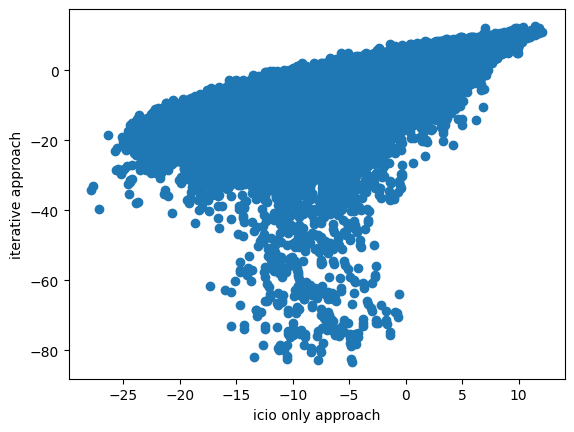

In [106]:
mat_plain = np.log(international_matrix.flatten())
mat_iter = np.log(international_matrix2.flatten())
plt.xlabel("icio only approach")
plt.ylabel("iterative approach")
plt.scatter(mat_plain, mat_iter)
plt.show()